In [434]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import os
import time
import skimage.measure
import subprocess
import random
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from sklearn.neighbors import KDTree

from mayavi import mlab
import plyfile
from pyntcloud import PyntCloud
from plyfile import PlyData

import deep_sdf
import deep_sdf.workspace as ws
from reconstruct import reconstruct

from custom_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## F decalration

Model F(p) - distance of the point from the sphere

In [435]:
RADIUS = 0.25

def mod(x, y, z):
    return x ** 2 + y ** 2 + z ** 2

def compute_loss(x, y, z):
    return (RADIUS - mod(x, y, z)) ** 2

def grad_modulo(x, y, z):
    return 4 * (RADIUS - mod(x, y, z)) * (mod(x, y, z) ** (1/2))

def deriv_sign(x, y, z):
    return 1

### Load stuff

In [436]:
experiment_directory = "/cvlabdata2/home/artem/DeepSDF/examples/sofas/"
checkpoint = "latest"

decoder = load_model(experiment_directory, checkpoint)
decoder.eval()

Decoder(
  (lin0): Linear(in_features=259, out_features=512, bias=True)
  (lin1): Linear(in_features=512, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=253, bias=True)
  (lin4): Linear(in_features=512, out_features=512, bias=True)
  (lin5): Linear(in_features=512, out_features=512, bias=True)
  (lin6): Linear(in_features=512, out_features=512, bias=True)
  (lin7): Linear(in_features=512, out_features=512, bias=True)
  (lin8): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
  (th): Tanh()
)

In [437]:
latent_vectors = ws.load_latent_vectors(experiment_directory, checkpoint)
latent_size = latent_vectors[0].size()[1]
print(f"{len(latent_vectors)} of latent vectors, each {latent_size} long")

initial_latent = latent_vectors[99].clone()

1628 of latent vectors, each 256 long


## Get a point that has 0 SDF value

In [438]:
def get_sdf_predictions(decoder, latent, points):
    return deep_sdf.utils.decode_sdf(decoder, latent, points).squeeze(1).detach().cpu().numpy()

In [439]:
def get_points_on_surface(decoder, latent, points, num_iters=100, lr=0.2, decreased_by=2, adjust_lr_every=5):

    def adjust_learning_rate(
        initial_lr, optimizer, num_iterations, decreased_by, adjust_lr_every
    ):
        lr = initial_lr * ((1 / decreased_by) ** (num_iterations // adjust_lr_every))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
    
    decoder.eval()

    current_points = torch.cuda.FloatTensor(points)
    current_points.requires_grad = True
    latent = torch.Tensor(latent.cpu().detach().numpy()).cuda()
    ref_sdf = torch.cuda.FloatTensor([[0]] * len(points))
    
    optimizer = torch.optim.Adam([current_points], lr=lr)
    loss_l1 = torch.nn.L1Loss()
    
    for i in range(num_iters):
        adjust_learning_rate(lr, optimizer, i, decreased_by, adjust_lr_every)
        
        sdf_value = deep_sdf.decode_sdf(decoder, latent, current_points)
        
        optimizer.zero_grad()
        loss = loss_l1(sdf_value, ref_sdf)
        loss.backward()
        optimizer.step()
        
    return current_points

In [440]:
null_points = get_points_on_surface(decoder, initial_latent, [[0, 0, 1], [0, 0, 0], [1, 0, 0]])
get_sdf_predictions(decoder, initial_latent, null_points)

array([-1.3214958e-07,  4.8224683e-07,  7.2613693e-07], dtype=float32)

## Full cycle

In [441]:
def optimize_shape(decoder, latent, num_points=10, 
                   num_iters=100, get_grad=grad_modulo, 
                   get_sign=deriv_sign, loss=compute_loss,
                   lr=0.2, decreased_by=2, adjust_lr_every=10):

    def adjust_learning_rate(
        initial_lr, optimizer, num_iterations, decreased_by, adjust_lr_every
    ):
        lr = initial_lr * ((1 / decreased_by) ** (num_iterations // adjust_lr_every))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
    
    decoder.eval()
    latent = torch.Tensor(latent.cpu().detach().numpy()).cuda()
    latent.requires_grad = True
    optimizer = torch.optim.Adam([latent], lr=lr)
    
    loss_hist = []
    
    for i in tqdm(range(num_iters)):
        adjust_learning_rate(lr, optimizer, i, decreased_by, adjust_lr_every)
        optimizer.zero_grad()
        points = get_points_on_surface(decoder, latent.clone(), np.random.rand(num_points,3))

        sdf_value = deep_sdf.utils.decode_sdf(decoder, latent, points)
        # [[1.0]] * len(points)
        sdf_value.backward(torch.cuda.FloatTensor([[deriv_sign(x,y,z) *  grad_modulo(x,y,z)] for x, y, z in points]))
        optimizer.step()
        
        loss = 0
        for x, y, z in points:
            loss += compute_loss(x, y, z)
        loss_hist.append(loss.detach().cpu().numpy())

    return latent, loss_hist

## Initial mesh

In [442]:
plot_mesh_from_vector(decoder, initial_latent, N=128)

sampling takes: 4.907181


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.001709029427729547, 0.3843526989221573, 0…

## Num points = 1

In [443]:
initial_latent = latent_vectors[99].clone()
opt_latent, loss_hist = optimize_shape(decoder, initial_latent, num_points=1, num_iters=30, adjust_lr_every=10)

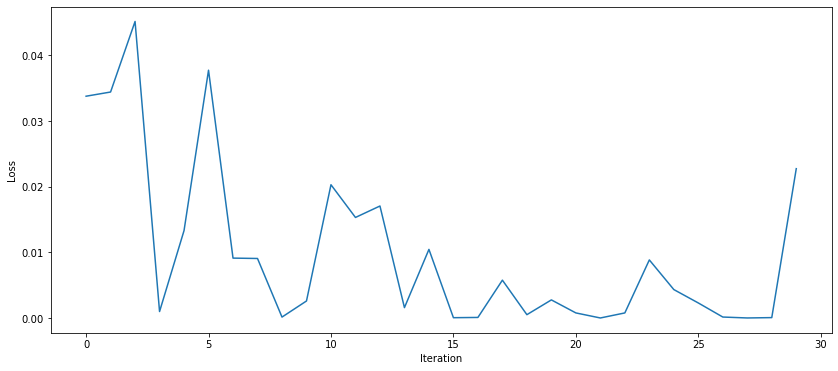

In [449]:
plt.figure(figsize=(14, 6))
#plt.yscale("log")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(loss_hist)
plt.show()

In [450]:
plot_mesh_from_vector(decoder, opt_latent, N=128)

sampling takes: 5.167157


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.014768175780773163, -0.24152078293263912,…

## Num points = 10

In [455]:
initial_latent = latent_vectors[99].clone()
opt_latent, loss_hist = optimize_shape(decoder, initial_latent, num_points=10, num_iters=30, adjust_lr_every=10)

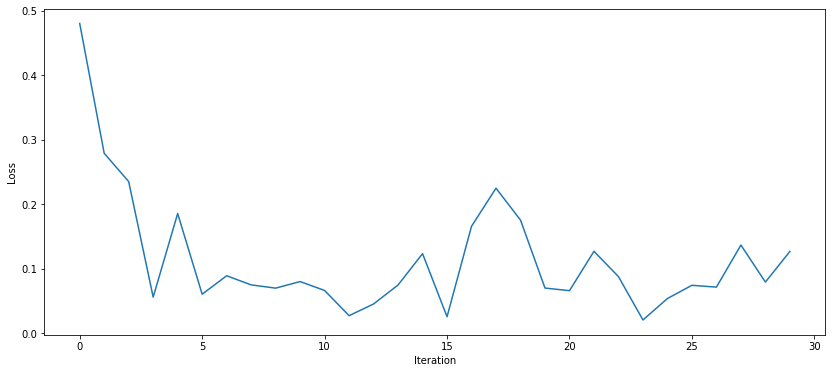

In [454]:
plt.figure(figsize=(14, 6))
#plt.yscale("log")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(loss_hist)
plt.show()

In [456]:
plot_mesh_from_vector(decoder, opt_latent, N=128)

sampling takes: 4.983086


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.03748041018843651, 0.4777846075594425, 0.5…

## Num points = 100

In [457]:
initial_latent = latent_vectors[99].clone()
opt_latent, loss_hist = optimize_shape(decoder, initial_latent, num_points=100, num_iters=30, adjust_lr_every=10)

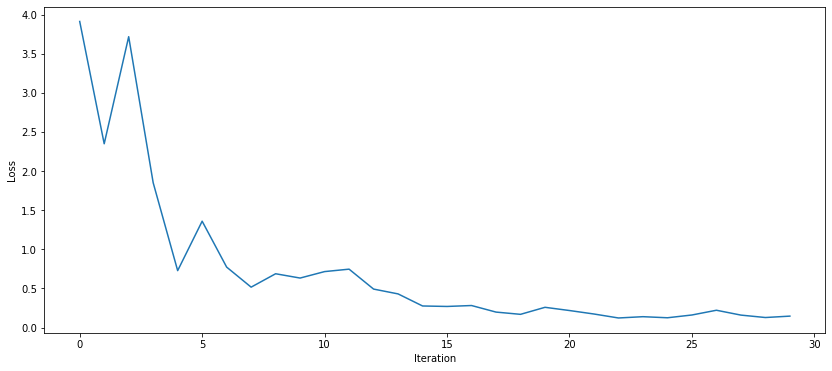

In [458]:
plt.figure(figsize=(14, 6))
#plt.yscale("log")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(loss_hist)
plt.show()

In [459]:
plot_mesh_from_vector(decoder, opt_latent, N=128)

sampling takes: 5.013625


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.007740662898868322, 0.498843664303422, 0.7…